<a href="https://colab.research.google.com/github/woncoh1/era1a8/blob/main/nbs/S8_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary: batch normalization
- Dataset: CIFAR-10
- Model: CNN
- Normalization: BN

## Targets
- Test accuracy > 70.0 %
- Number of parameters < 50,000
- Number of epochs <= 20

## Results
- Best train accuracy = 76.26 %
- Best test accuracy = 79.49 %
- Number of Parameters = 49,040
- Number of Epochs = 20


In [ ]:
!git clone https://github.com/woncoh1/era1a8.git

Cloning into 'era1a8'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 70 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (70/70), 21.79 KiB | 1.36 MiB/s, done.


In [ ]:
%pip install torchinfo -Uqq

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchinfo import summary

from era1a8.src import data, engine, models, utils

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [ ]:
transform = {
    'train': transforms.Compose([
        # https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), # Standardization: [0, 1]
        transforms.Normalize(data.AVG, data.STD), # Normalization: shift and scale
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(), # Standardization
        transforms.Normalize(data.AVG, data.STD), # Normalization
    ]),
}

## Dataset

In [ ]:
dataset = data.get_dataset(transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 13015589.05it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


## DataLoader

In [ ]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [ ]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

Files already downloaded and verified


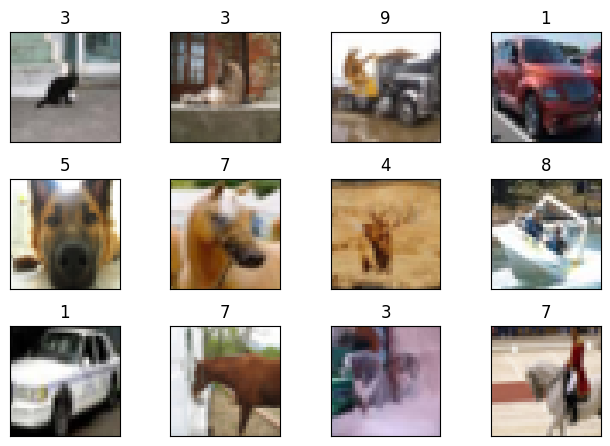

In [ ]:
utils.plot_batch(
    data.get_dataloader(
        data.get_dataset({
            'train': transforms.ToTensor(),
            'test': transforms.ToTensor(),
        }),
        params_dataloader,
    )['train']
)

# Model

In [ ]:
params_model = {
    'dropout': 0,
    'groups': 2,
}

criterion = F.nll_loss
model = (
    models
    .Net(norm='bn', grps=params_model['groups'], drop=params_model['dropout'])
    .apply(utils.initialize_weights)
    .to(device)
)

summary(
    model,
    input_size=(params_dataloader['batch_size'], *data.CHW),
    row_settings=['var_names'],
)

Layer (type (var_name))                  Output Shape              Param #
Net (Net)                                [128, 10]                 --
├─Sequential (conv1)                     [128, 8, 32, 32]          --
│    └─Conv2d (0)                        [128, 8, 32, 32]          216
│    └─BatchNorm2d (1)                   [128, 8, 32, 32]          16
│    └─Dropout2d (2)                     [128, 8, 32, 32]          --
│    └─ReLU (3)                          [128, 8, 32, 32]          --
├─SkipBlock (conv2)                      [128, 8, 32, 32]          --
│    └─Conv2d (conv1)                    [128, 8, 32, 32]          584
│    └─BatchNorm2d (norm1)               [128, 8, 32, 32]          16
│    └─Dropout2d (drop1)                 [128, 8, 32, 32]          --
│    └─Conv2d (conv2)                    [128, 8, 32, 32]          584
│    └─BatchNorm2d (norm2)               [128, 8, 32, 32]          16
│    └─Dropout2d (drop2)                 [128, 8, 32, 32]          --
├─SkipBlock 

# Trainer
- Weight optimizer
- Learning-rate scheduler

In [ ]:
params_trainer = {
    'num_epochs': 20,
}
params_optimizer = {
    'lr': 0.1,
    'momentum': 0.9,
}
params_scheduler = {
    'max_lr': params_optimizer['lr'],
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01589, Accuracy = 25.11%, Epoch = 1
Test : Loss = 0.01384, Accuracy = 37.13%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01332, Accuracy = 37.52%, Epoch = 2
Test : Loss = 0.01217, Accuracy = 44.26%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01163, Accuracy = 46.25%, Epoch = 3
Test : Loss = 0.01011, Accuracy = 53.91%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01039, Accuracy = 52.18%, Epoch = 4
Test : Loss = 0.01149, Accuracy = 46.73%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00959, Accuracy = 56.01%, Epoch = 5
Test : Loss = 0.00957, Accuracy = 58.96%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00901, Accuracy = 59.04%, Epoch = 6
Test : Loss = 0.00833, Accuracy = 63.23%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00850, Accuracy = 61.64%, Epoch = 7
Test : Loss = 0.00780, Accuracy = 64.84%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00807, Accuracy = 63.66%, Epoch = 8
Test : Loss = 0.00690, Accuracy = 69.39%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00779, Accuracy = 65.15%, Epoch = 9
Test : Loss = 0.00681, Accuracy = 70.62%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00753, Accuracy = 66.29%, Epoch = 10
Test : Loss = 0.00649, Accuracy = 70.71%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00723, Accuracy = 67.65%, Epoch = 11
Test : Loss = 0.00717, Accuracy = 68.34%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00703, Accuracy = 68.74%, Epoch = 12
Test : Loss = 0.00609, Accuracy = 72.70%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00679, Accuracy = 69.76%, Epoch = 13
Test : Loss = 0.00864, Accuracy = 63.89%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00652, Accuracy = 70.77%, Epoch = 14
Test : Loss = 0.00625, Accuracy = 73.43%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00636, Accuracy = 71.57%, Epoch = 15
Test : Loss = 0.00555, Accuracy = 75.86%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00612, Accuracy = 72.58%, Epoch = 16
Test : Loss = 0.00528, Accuracy = 77.06%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00589, Accuracy = 73.87%, Epoch = 17
Test : Loss = 0.00540, Accuracy = 76.24%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00566, Accuracy = 74.85%, Epoch = 18
Test : Loss = 0.00485, Accuracy = 78.97%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00546, Accuracy = 75.63%, Epoch = 19
Test : Loss = 0.00479, Accuracy = 79.49%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00532, Accuracy = 76.26%, Epoch = 20
Test : Loss = 0.00472, Accuracy = 79.44%



## LR finder
Find the optimal `max_lr` for the one cycle policy:
- https://sgugger.github.io/the-1cycle-policy.html
- https://iconof.com/1cycle-learning-rate-policy

In [ ]:
trn = data.get_dataloader(dataset, params_dataloader)['train']
net = (
    models
    .Net(norm='bn', grps=params_model['groups'], drop=params_model['dropout'])
    .apply(utils.initialize_weights)
    .to(device)
)
opt = optim.SGD(net.parameters(), **params_optimizer)
lrs, losses = utils.find_lr(device, trn, net, criterion, opt)

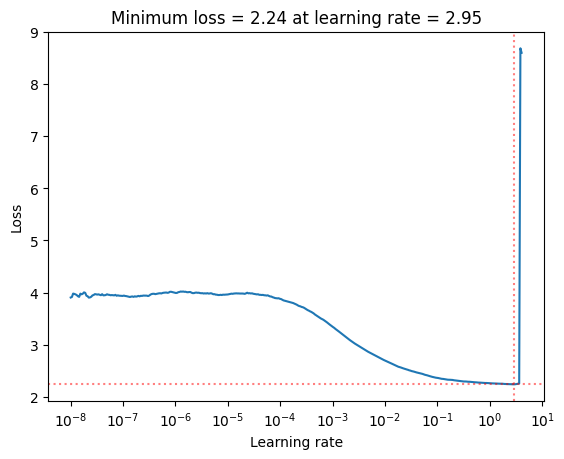

In [ ]:
utils.plot_lr(lrs, losses)

# Evaluate

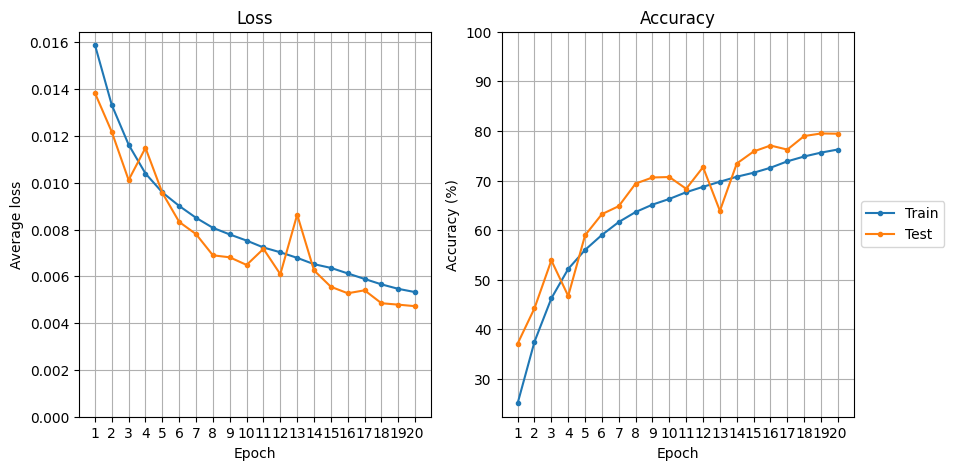

In [ ]:
utils.plot_curves(results, params_trainer['num_epochs'])

## Wrong predictions

In [ ]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, params_dataloader)['test'],
    model,
    criterion
)

Total Incorrect Predictions 2056


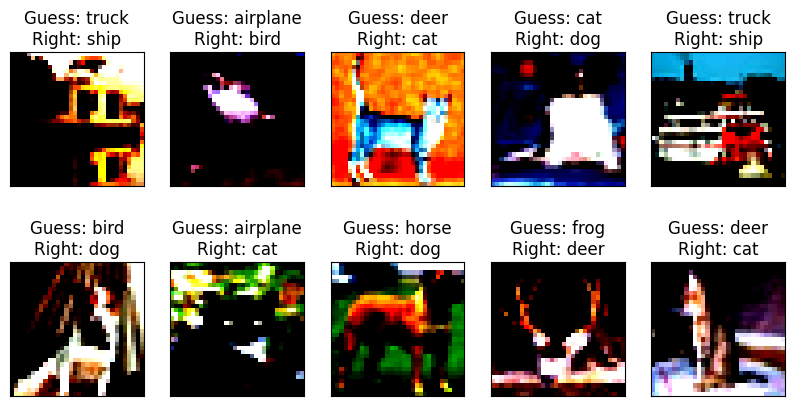

In [ ]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)